In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\pyth

In [2]:
tf.set_random_seed(1)
np.random.seed(1)

BATCH_SIZE = 50
LR = 0.001              # learning rate

mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)  # they has been normalized to range (0,1)
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000, 10)


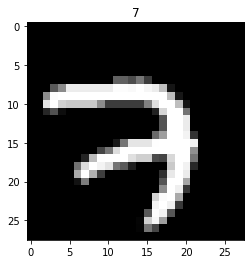

In [3]:
# plot one example
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)   # (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0])); plt.show()

tf_x = tf.placeholder(tf.float32, [None, 28*28]) / 255.
image = tf.reshape(tf_x, [-1, 28, 28, 1])              # (batch, height, width, channel)
tf_y = tf.placeholder(tf.int32, [None, 10])            # input y

In [4]:
# CNN
'''
tf.nn.conv2d函數是tensoflow裡面的二維的捲積函數，x是圖片的所有參數，W是此卷積層的權重，
然後定義步長strides=[1,1,1,1]值，strides[0]和strides[3]的兩個1是默認值，
中間兩個1代表padding時在x方向運動一步，y方向運動一步
'''
with tf.variable_scope('conv1'):
    conv1 = tf.layers.conv2d(   # shape (28, 28, 1)
        inputs=image,
        filters=16,
        kernel_size=5,
        strides=1,
        padding='same',
        activation=tf.nn.relu,
        name='conv1'
    )           # -> (28, 28, 16)

'''
pooling 有兩種，一種是最大值池化，一種是平均值池化，本例採用的是最大值池化tf.max_pool()。
池化的核函數大小為2x2，因此ksize=[1,2,2,1]，步長為2，因此strides=[1,2,2,1]
'''
with tf.variable_scope('pool1'):
    pool1 = tf.layers.max_pooling2d(
        conv1,
        pool_size=2,
        strides=2,
    )           # -> (14, 14, 16)
    
with tf.variable_scope('conv2'):    
    conv2 = tf.layers.conv2d(pool1, 32, 5, 1, 'same', activation=tf.nn.relu)    # -> (14, 14, 32)

with tf.variable_scope('pool2'):
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2)    # -> (7, 7, 32)  


with tf.variable_scope('output'):
    flat = tf.reshape(pool2, [-1, 7*7*32])          # -> (7*7*32, )
    output = tf.layers.dense(flat, 10)              # output layer

with tf.name_scope('loss'):
    loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost
    tf.summary.scalar('loss', loss)     # add loss to scalar summary

    
with tf.name_scope('train'):
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)
    

accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op

writer = tf.summary.FileWriter('cnn/', sess.graph)     # write to file
merge_op = tf.summary.merge_all()                       # operation to merge all summary
print(merge_op)

sess.run(init_op)     # initialize var in graph

Tensor("Merge/MergeSummary:0", shape=(), dtype=string)


In [5]:
'''Scalar
在人工智慧當中可以使用Scalar來記錄每一次準確度、損失數值等等，最後結果類似一張折線圖。

範例
使用merge_all函數取得目前設定可視化的集合，而這裡就是tf.summary.scalar("count", input)，
最後跑迴圈並將運行summary_op寫入檔案，最後結果如下圖畫出0~100

https://ithelp.ithome.com.tw/articles/10210726
'''

help(writer.add_summary)


Help on method add_summary in module tensorflow.python.summary.writer.writer:

add_summary(summary, global_step=None) method of tensorflow.python.summary.writer.writer.FileWriter instance
    Adds a `Summary` protocol buffer to the event file.
    
    This method wraps the provided summary in an `Event` protocol buffer
    and adds it to the event file.
    
    You can pass the result of evaluating any summary op, using
    @{tf.Session.run} or
    @{tf.Tensor.eval}, to this
    function. Alternatively, you can pass a `tf.Summary` protocol
    buffer that you populate with your own data. The latter is
    commonly done to report evaluation results in event files.
    
    Args:
      summary: A `Summary` protocol buffer, optionally serialized as a string.
      global_step: Number. Optional global step value to record with the
        summary.



In [6]:
saver = tf.train.Saver()  # define a saver for saving and restoring
save_path = 'cnn/model.ckpt'
for step in range(10000):
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _,loss_ = sess.run([train_op,loss], {tf_x: b_x, tf_y: b_y}) 
    result = sess.run(merge_op, {tf_x: b_x, tf_y: b_y}) 
    writer.add_summary(result, step)
    if step % 50 == 0:
        saver.save(sess, save_path, global_step=step)
        accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_x, tf_y: test_y})
        print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

Step: 0 | train loss: 2.2956 | test accuracy: 0.14
Step: 50 | train loss: 0.3620 | test accuracy: 0.48
Step: 100 | train loss: 0.2210 | test accuracy: 0.61
Step: 150 | train loss: 0.2453 | test accuracy: 0.69
Step: 200 | train loss: 0.1991 | test accuracy: 0.74
Step: 250 | train loss: 0.2199 | test accuracy: 0.77
Step: 300 | train loss: 0.0810 | test accuracy: 0.79
Step: 350 | train loss: 0.0708 | test accuracy: 0.81
Step: 400 | train loss: 0.1082 | test accuracy: 0.83
Step: 450 | train loss: 0.0785 | test accuracy: 0.84
Step: 500 | train loss: 0.1935 | test accuracy: 0.85
Step: 550 | train loss: 0.1186 | test accuracy: 0.86
Step: 600 | train loss: 0.1862 | test accuracy: 0.87
Step: 650 | train loss: 0.0485 | test accuracy: 0.88
Step: 700 | train loss: 0.0267 | test accuracy: 0.88
Step: 750 | train loss: 0.0946 | test accuracy: 0.89
Step: 800 | train loss: 0.0693 | test accuracy: 0.89
Step: 850 | train loss: 0.0185 | test accuracy: 0.90
Step: 900 | train loss: 0.1487 | test accuracy: 0

Step: 7650 | train loss: 0.0015 | test accuracy: 0.97
Step: 7700 | train loss: 0.0084 | test accuracy: 0.97
Step: 7750 | train loss: 0.0009 | test accuracy: 0.97
Step: 7800 | train loss: 0.0016 | test accuracy: 0.97
Step: 7850 | train loss: 0.0008 | test accuracy: 0.97
Step: 7900 | train loss: 0.0013 | test accuracy: 0.97
Step: 7950 | train loss: 0.0021 | test accuracy: 0.97
Step: 8000 | train loss: 0.0034 | test accuracy: 0.97
Step: 8050 | train loss: 0.0024 | test accuracy: 0.97
Step: 8100 | train loss: 0.0189 | test accuracy: 0.97
Step: 8150 | train loss: 0.0145 | test accuracy: 0.97
Step: 8200 | train loss: 0.0025 | test accuracy: 0.97
Step: 8250 | train loss: 0.0002 | test accuracy: 0.97
Step: 8300 | train loss: 0.2152 | test accuracy: 0.97
Step: 8350 | train loss: 0.0002 | test accuracy: 0.98
Step: 8400 | train loss: 0.0040 | test accuracy: 0.98
Step: 8450 | train loss: 0.0058 | test accuracy: 0.98
Step: 8500 | train loss: 0.0228 | test accuracy: 0.98
Step: 8550 | train loss: 0.0

# Saver 保存讀取

In [7]:
def save():  
    saver = tf.train.Saver()  # define a saver for saving and restoring
    saver.save(sess, save_path)  # meta_graph is not recommended       

save()

In [8]:
# destroy previous net
tf.reset_default_graph()

def reload():
    print('This is reload')
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(save_path))       
        if ckpt and ckpt.model_checkpoint_path:
#             print(tf.train.latest_checkpoint('cnn'))            
            print('Found checkpoint, try to restore...')
            saver = tf.train.import_meta_graph(''.join([ckpt.model_checkpoint_path, '.meta']))   
            saver.restore(sess, tf.train.latest_checkpoint(save_path.replace('model.ckpt','')))

            # 列印出網路中可訓練的權重引數名
            for var in tf.trainable_variables():
                print(var)           
reload() 

This is reload
Found checkpoint, try to restore...
INFO:tensorflow:Restoring parameters from cnn\model.ckpt
<tf.Variable 'conv1/conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1/conv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv2/conv2d/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>
<tf.Variable 'conv2/conv2d/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'output/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>
<tf.Variable 'output/dense/bias:0' shape=(10,) dtype=float32_ref>


# Reload 後繼續train

In [9]:
for step in range(1000):
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _,loss_ = sess.run([train_op,loss], {tf_x: b_x, tf_y: b_y}) 
    result = sess.run(merge_op, {tf_x: b_x, tf_y: b_y}) 
    writer.add_summary(result, step)
    if step % 50 == 0:
        saver.save(sess, save_path, global_step=step)
        accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_x, tf_y: test_y})
        print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

Step: 0 | train loss: 0.0003 | test accuracy: 0.98
Step: 50 | train loss: 0.0055 | test accuracy: 0.98
Step: 100 | train loss: 0.0008 | test accuracy: 0.98
Step: 150 | train loss: 0.0001 | test accuracy: 0.98
Step: 200 | train loss: 0.0015 | test accuracy: 0.98
Step: 250 | train loss: 0.0002 | test accuracy: 0.98
Step: 300 | train loss: 0.0199 | test accuracy: 0.98
Step: 350 | train loss: 0.0071 | test accuracy: 0.98
Step: 400 | train loss: 0.0452 | test accuracy: 0.98
Step: 450 | train loss: 0.0018 | test accuracy: 0.98
Step: 500 | train loss: 0.0006 | test accuracy: 0.98
Step: 550 | train loss: 0.0027 | test accuracy: 0.98
Step: 600 | train loss: 0.0038 | test accuracy: 0.98
Step: 650 | train loss: 0.0037 | test accuracy: 0.98
Step: 700 | train loss: 0.0053 | test accuracy: 0.98
Step: 750 | train loss: 0.0010 | test accuracy: 0.98
Step: 800 | train loss: 0.0002 | test accuracy: 0.98
Step: 850 | train loss: 0.0026 | test accuracy: 0.98
Step: 900 | train loss: 0.0002 | test accuracy: 0